<hr style="border:0.2px solid black"> </hr>

<figure>
  <IMG SRC="ntnu_logo.png" WIDTH=200 ALIGN="right">
</figure>

**<ins>Course:</ins>** TVM4174 - Hydroinformatics for Smart Water Systems

# <ins>Group project:</ins> Resilience in water distribution system
    
*Developed by Louise Horn Buøen and Fredrik Strifeldt*
    
<hr style="border:0.2px solid black"> </hr>

## Introduction
Water distribution systems is a crucial element of urban infrastructure, providing safe drinking water to support human health, economic activity, and the environment. Meanwhile, water distribution systems face numerous challenges that put their ability to maintain good water quality at risk. Water quality models are essential for being able to predict and control the quality in the water network systems. A wide variety of hydraulic and water quality parameters can be used to simulate how the system behaves over time. WNTR is a python package that can be used to better understand how different scenarios will affect the system and can help to plan for a more a more resilient water distribution system.


## Aim of notebook
This notebook will explain how WNTR can be used to simulate different disaster events like:
- Closing a pipe
- Fire fighting
- Pipe leak
- Power outage

and illustrate how these scenarios impact the network.


Disclaimer:
- The codes presented in this notebook fits network Net1.inp. If other network is to be used, adjustments in the codes may be necessary.
- General knowledge about python and EPANET is required as a minimum to understand the concept of this notebook.

#### Installing WNTR and all the necessary python packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wntr

## Simulation options
When running a water network simulation in WNTR, there is a variety of different simulation options to choose from, some of them being related to
- Simulation time
- Hydraulics of network
- Water quality modeling and reactions
- Graphics for presenting simulation results

These options are found in the `wntr.network.options`module, and can be adjusted for different water network analyses. This notebook will focus on `TimeOptions`and `HydraulicOptions`.

#### Time options

Options related to time are set according to the EPANET 2.2 'time' settings, and includes for instance `time.duration`,`time.hydraulic_timestep` and `time.pattern_start`.

#### Hydrualic options
The hydraulic options for the water network simulation are also set according to the EPANET 2.2 model. Many of them already having a default value, for instance headloss formula, viscosity and specific gravity. This module also sets the minimum and required pressure at the nodes.

#### Understanding the difference of demand driven simulation and pressure dependet demand simulation
The demand driven (DD) simulation and the pressure dependent demand (PDD) simulation are two approaches to hydrualic modelling of a water network, representing different pressure scenarios. 

The pressure in a DD simulation depends on the node demands, assuming that the nodal flows are always satisfied at all demand nodes regardless of the pressure available. This assumption is reasonable during normal operating conditions. 


When the system is not under normal conditions, for instance during earthquakes, in fire fighting situations, power outages, pipe leaks and pipe closures, the demand at a node decreases when the pressure is below the `required pressure`, and the demand goes to 0 when the pressure is below the `minimum pressure`.

For further reading, see 
- [PDD and DD](https://pure.strath.ac.uk/ws/portalfiles/portal/44432218/Seyoum_etal_CCWI_2011_Comparison_of_demand_driven_and_pressure_dependent_hydraulic_approaches.pdf)
- [Simulation Options](https://wntr.readthedocs.io/en/stable/apidoc/wntr.network.options.html#wntr.network.options.Options)

#### Loading the EPANET model and building the simulation model

In [2]:
# Loading the EPANET model
inp_file = 'Net1.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Setting the lenght of the simulation and choosing PDD as the demand solver
analysis_length = 72*3600 
wn.options.time.duration = analysis_length
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 20
wn.options.hydraulic.minimum_pressure = 0

#### Network population 
WNTR can compute the population per node, using demand and average volume of water consumed per capita per day in m3/s (R). 
By default, WNTR sets average water consumption per capita per day to 8.76157e-06 m3/s = 200 gallons/day = 757 litres/day. However, in this notebook the average water consumption per capita per day is assumed to be 200 litres/day = 2.3148e06 m3/s.
In the code below, it is shown how changing the R value affects the size of population of the network.

By having this information, it can be used as a variable when trying to understand the water network and deciding the importance of different pipes.

In [3]:
population1 = wntr.metrics.population(wn, R=2.3148e-06 ) #200 l/day
population2 = wntr.metrics.population(wn)                #200 gallons/day
print('Population of network is', int(population1.sum()), 'people when R = 200 l/day.')
print('Population of network is', int(population2.sum()), 'people when R = 200 gallons/day.')
pop_df = pd.DataFrame(population1)

Population of network is 29981 people when R = 200 l/day.
Population of network is 7920 people when R = 200 gallons/day.


## Closing pipe simulation using Water Network Controls
WNTR is capable of controlling pipes, pumps and valves in the water network using simple and complex conditions. EPANET defines these conditions as either 'control' or 'rule'. This notebook will provide instructions on how to use 'control', click [here](https://wntr.readthedocs.io/en/stable/controls.html#rules) for further information on 'rule'.

#### Controls
Controls are defined using an "IF condtion; THEN action" setup, meaning that a single action is based on a single condition.
The `wntr.network.controls` module is a set of methods that modify parameters and actions in the network during a simulation of the network; it takes an instance of any conditions given, along with an action that should occur when the condition is true.

#### Action
The `Action class` is apllied when defining a controlable action in the network.`wntr.network.controlAction` is an example, and it simply modifies the attribute of a given target object.

#### Condition
The condition decides when the action occurs. There are multiple condition classes that can be used, for instance, an action can be set to occur on a specific time of day (`TimeOfDayCondition`), by comparing threshold values in tanklevels (`RelativeCondition`) or simply by a given time since start of network simulation (`SimTimeCondition`).

## Example Controls: One action, two different conditions
The following code shows how a pipe is closed (action) when
- the simulation starts, at 0 hours (condition 1)
- the threshold of tank1 is set to 50 (condition 2)

#### Loading the EPANET model

In [4]:
inp_file = 'Net1.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

analysis_length = 72*3600 
wn.options.time.duration = analysis_length
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 20
wn.options.hydraulic.minimum_pressure = 0

#### Setting target objects, actions and conditions

In [5]:
pipe = wn.get_link('10')
tank = wn.get_node('2')
action = wntr.network.controls.ControlAction(pipe, 'status', wntr.network.LinkStatus.Closed)

condition1 = wntr.network.controls.SimTimeCondition(wn, '=', '00:00:00')
control1 = wntr.network.controls.Control(condition1, action)
print(control1)

condition2 = wntr.network.controls.ValueCondition(tank, 'level', '>', 50.00)
control2 = wntr.network.controls.Control(condition2, action, name='control2')
print(control2)

IF SYSTEM TIME IS 00:00:00 THEN PIPE 10 STATUS IS CLOSED PRIORITY 3
IF TANK 2 LEVEL ABOVE 50.0 THEN PIPE 10 STATUS IS CLOSED PRIORITY 3


As the code shows, it is possible to adjust the conditions and actions for the control.

#### Adding control1 to the network
To see how condition1 impacts the pressure and the demand of the water network, a new simulation is ran and compared to the network at normal conditions:

In [6]:
#Adding the action and condition to water network
wn.reset_initial_values()
wn.add_control(pipe, control1)

#Simulating network with the control
sim = wntr.sim.WNTRSimulator(wn)
control_results = sim.run_sim()

#Removing the control
wn.reset_initial_values()
wn.remove_control(pipe)

#Simulating network with normal conditions
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

#### Plotting pressure the 20th hour 

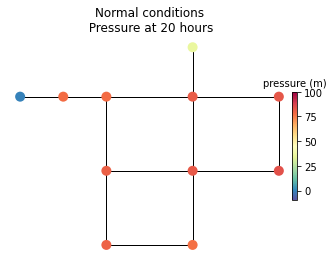

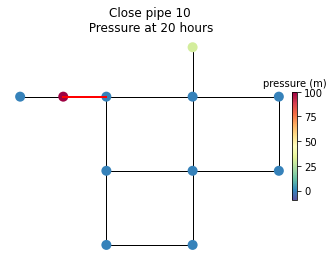

In [7]:
pressure_cp = control_results.node['pressure'].loc[20*3600, :]
pressure_nc = results.node['pressure'].loc[20*3600, :]

wntr.graphics.plot_network(wn, 
                           node_attribute=pressure_nc, 
                           node_size=100, 
                           node_range=[-10,100],
                           node_colorbar_label = 'pressure (m)',
                           title=f'Normal conditions\n Pressure at 20 hours')
wntr.graphics.plot_network(wn, 
                           node_attribute=pressure_cp, 
                           node_size=100, 
                           node_range=[-10,100],
                           node_colorbar_label = 'pressure (m)',
                           title=f'Close pipe {pipe.name}\n Pressure at 20 hours')

#Plotting relevant pipe in network
start_node = pipe.start_node
end_node = pipe.end_node
x_start ,y_start = start_node.coordinates
x_end, y_end = end_node.coordinates
x_values=[x_start, x_end]
y_values=[y_start, y_end]
plt.plot(x_values, y_values, linewidth=2, color = 'red')
plt.show()

Pipe 10 is connecting the reservoir to the rest of the network, so it is no suprise by closing of this pipe, the network will not be supplied with water anymore and the pressure drops to zero. If maintainance is needed to be done at this specific pipe, an extra pipe is needed to be built before closing the original pipe off, indicating that the system is not very resilient seen from a maintainance prespective.

## Fire fighting simulation
When planning a water network, it is necessary to design for water supply for fire fighting. The Firemen will always prioritise to save lifes, their main focus is to extinguish the fire - using as much water as needed. If the network is not designed well, this sudden change in the node demand, can for instance result in negative pressure and too high velocity, which again will affect the water quality. 

Therefore it is essential to implement this type of water demand in the hydraulic models. Byggteknisk Forskrift requires that it is possible to retrieve 50 l/s for two hours in populated areas.

#### Adding fire demand to the water network
The code below shows how to add fire demand to a network, using `add_fire_demand`, and how this affect the pressure in the system.

#### Loading the EPANET model

In [8]:
inp_file = 'Net1.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

analysis_length = 72*3600 
wn.options.time.duration = analysis_length
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 20
wn.options.hydraulic.minimum_pressure = 0

In [9]:
# Adding fire demand
fire_flow_demand = 0.05 #50l/s = 0.05 m3/s

# Letting the fire fighting run for 2 hours
fire_start = 10*3600
fire_end = 12*3600

# Choosing a node where the firemen connect their hoses to
node = wn.get_node('11')

# Adding the fire fighting to the water network
node.add_fire_fighting_demand(wn, fire_flow_demand, fire_start, fire_end)

#Simulating the fire fighting
wn.reset_initial_values()
sim = wntr.sim.WNTRSimulator(wn)
fire_results = sim.run_sim()

# Resetting initial values and simulate hydraulics during normal conditions
wn.reset_initial_values()
node.remove_fire_fighting_demand(wn)
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

#### Plotting the pressure at the 11th hour 
At the 11th hour, the firefighting has lasted for one hour, and some changes in the network hydraulics is expected.

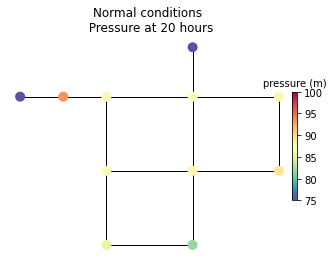

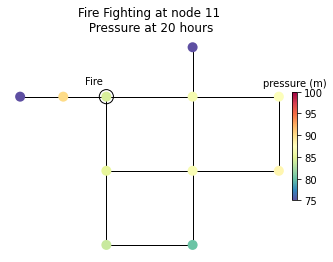

In [10]:
pressure_ff = fire_results.node['pressure'].loc[11*3600, :]
pressure_nc = results.node['pressure'].loc[11*3600, :]
pressure_difference = pressure_nc - pressure_ff

wntr.graphics.plot_network(wn, 
                           node_attribute=pressure_nc, 
                           node_size=100, 
                           node_range=[75,100],
                           node_colorbar_label = 'pressure (m)',
                           title=f'Normal conditions \n Pressure at 20 hours')
wntr.graphics.plot_network(wn, 
                           node_attribute=pressure_ff, 
                           node_size=100, 
                           node_range=[75,100],
                           node_colorbar_label = 'pressure (m)',
                           title=f'Fire Fighting at node {node.name}\n Pressure at 20 hours')

#plotting relevant node in network
x, y = node.coordinates
plt.scatter(x, y, s=200, facecolors='none', edgecolors='black')
plt.annotate('Fire', xy=(x-5,y+5));

Retrieving 50 l/s for one hour, results in some pressure changes in the systems. However, no negative pressure wil occur. This means the water network is resilient for this kind of fire fighting. 

## Pipe leaks
Pipe leaks are very common in water distribution systems. When the pipe gets older the material starts to detoriate and this can lead to pipe breaks. Other thing that can lead to pipe breaks is when the water in the pipe freeze and the pipe expand, or sudden pressure changes in the network. WNTR have the opportunity to add pipe leaks to the model either to a junction or a tank. 
There are two different ways to add a leak to a pipe, either by using the function `split_pipe` or `break_pipe`. The `split_pipe` function splits the old pipe into two pipes an adds a junction in between, and the `break_pipe` function breaks the pipe in two an adding two junctions, as shown in the figure below. 

<figure>
  <IMG SRC="pipeleak.jpg" WIDTH=800 ALIGN="center">
</figure>
    
More information about pipe leaks in WNTR can be found at the following sites:

* [Leak-model](https://wntr.readthedocs.io/en/latest/hydraulics.html#leak-model)
* [Pipe breaks or leaks](https://wntr.readthedocs.io/en/latest/disaster_models.html#pipe-breaks-or-leaks)
* [Split or break pipes](https://wntr.readthedocs.io/en/stable/morph.html#split-or-break-pipes)

In the following example a leak is going to be set at a specific pipe to see how it effects the pressure in the junctions using the `split_pipe` function.

#### Loading the EPANET model

In [11]:
# Loading the EPANET model
inp_file = 'Net1.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

analysis_length = 72*3600 
wn.options.time.duration = analysis_length
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 20
wn.options.hydraulic.minimum_pressure = 0

#### Introducing pipeleak to the network
Using the `split_pipe` function making a 8 hour leak:

In [12]:
# Add a leak to a pipe
wn = wntr.morph.split_pipe(wn, '22', '22_B', '22_leak_node')
node = wn.get_node('22_leak_node')
node.add_leak(wn, area=0.05, start_time=16*3600, end_time=24*3600)

# Run a simulation with the leak introduced
wn.reset_initial_values()
sim = wntr.sim.WNTRSimulator(wn)
results_leak = sim.run_sim()

# Resetting initial values and simulate hydraulics during normal conditions
wn.reset_initial_values()
node.remove_leak(wn)
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

#### Plotting the pressure at the 20th hour

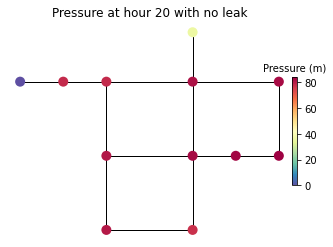

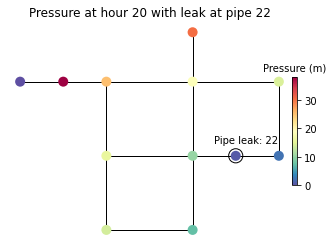

In [13]:
# Get all the pressure in nodes to a variable
pressure_at_20hr = results.node['pressure'].loc[20*3600, :]
pressure_with_leak_at_20hr = results_leak.node['pressure'].loc[20*3600, :]

# Plot of EPANET model with pressure in nodes
wntr.graphics.plot_network(wn, node_size=100,
                           title='Pressure at hour 20 with no leak',
                           node_attribute=pressure_at_20hr, 
                           node_colorbar_label='Pressure (m)')

wntr.graphics.plot_network(wn, node_size=100, 
                           title='Pressure at hour 20 with leak at pipe 22',
                           node_attribute=pressure_with_leak_at_20hr, 
                           node_colorbar_label='Pressure (m)')

x, y = node.coordinates
plt.scatter(x, y, s=200, facecolors='none', edgecolors='black')
plt.annotate('Pipe leak: 22', xy=(x-5,y+5));

When a eight hour leak is introduced in pipe 22 there is a large pressure drop in the whole system. This indicates that this pipe is very vulnerable to leaks. As seen in the plot below the pressure difference at the nodes is large. 

By having the opportunity to use the `split_pipe` function as shown, it is possible to iterate through each pipe in the network, adding a leak to the current pipe and running a simulation. By doing this it is possible to classify every pipe in the network and see what pipe is the most vulnerable.

## Power outage
A power outage is a loss of the electrial power to the end user. In a water distribution system this can effect the water pressure if the network, for instance contains, a pump. The duration of a power outage can vary, from hours to even days. If you have a drop in water pressure this can result in shortage in water in different part of the system. WNTR have the function to turn of the power to the pump and simulate a power outage. This can be used to see what effect it has on the systems pressure.

To read more about pumps and power outage please follow the links below:
* [Pumps](https://epanet22.readthedocs.io/en/latest/3_network_model.html)
* [Power outage](https://wntr.readthedocs.io/en/latest/disaster_models.html#power-outage)

In [14]:
# Loading the EPANET model
inp_file = 'Net1.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

analysis_length = 72*3600 
wn.options.time.duration = analysis_length
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 20
wn.options.hydraulic.minimum_pressure = 0

#### Printing information about the pump(s)
It is helpful to see if there is any pumps in the network, and to get  information about the pump(s).

In [15]:
wn.pump_name_list
pump = wn.get_link('9')
pump

<Pump '9' from '9' to '10', pump_type='HEAD', pump_curve=1, speed=<TimeSeries: base_value=1.0, pattern_name=None, category='None'>, status=Open>

#### Plotting the pump curve
Plotting the pumpe curve gives information about the relationship between the head and flow rate that is being delieverd at normal speed settings. A pump curve must have decreasing head with increasing flow to be valid. This can yield some information about how the pump operates under certain conditions. 

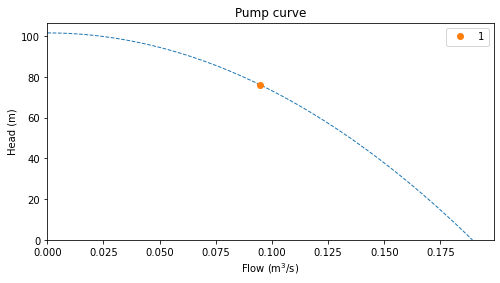

In [16]:
# Printing the pump curve to the pump in the water distribution system
ax = wntr.graphics.plot_pump_curve(pump)

This pump curve is called a single-point pump curve. This means that EPANET only have one design value for the head-flow combination. The way EPANET generates a polynomial function is by assuming a shut-off head at 133 % of the design value. It also makes a max flow limit at the double of the design value at zero head.

#### Closing water supply from tank
Earlier in this guide, it is shown how to close a pipe. This function will now be used to simulate that the tank has been cut of the system after 24 hours. By doing this it is only the reservoir that supplies the water distribution system. 

In [17]:
# Add a control to close water suplly from tank
pipe = wn.get_link('110')        
act = wntr.network.controls.ControlAction(pipe, 'status', wntr.network.LinkStatus.Closed)
cond = wntr.network.controls.SimTimeCondition(wn, '=', '24:00:00')
ctrl = wntr.network.controls.Control(cond, act)
wn.add_control(pipe, ctrl)

#### Running a simulation with the tank shut out of the system

In [18]:
# Run a simulation
wn.reset_initial_values()
sim = wntr.sim.WNTRSimulator(wn)
results_no_tank = sim.run_sim()

#### Plotting the results with closed pipe to tank when 30 hours have passed by

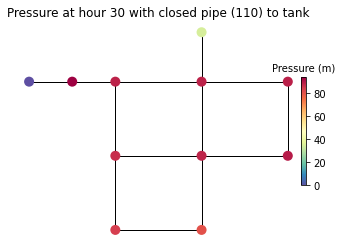

In [19]:
# Get all nodes with pressures after 30 hours
pressure_at_30hr = results_no_tank.node['pressure'].loc[30*3600, :]

# Plot of EPANET model with pressure in nodes
wntr.graphics.plot_network(wn, node_size=100, 
                           title='Pressure at hour 30 with closed pipe (110) to tank',
                           node_attribute=pressure_at_30hr, 
                           node_colorbar_label='Pressure (m)'
                          );

As seen in the plot, the pressure in the system is still sufficient while it is only the pump and reservoir supplying the water distribution system.

##### Simulating power outage

Now that we know that the water distribution system have a pump, the next thing is to do is to simulate a power outage. This can be done by changing the pump status from ON to OFF for a duration of time. The supply from the water tank was stoppet after 24 hours. The power outage is added from hour 32 to 36.

In [20]:
# Adding a power outage to the pump
pump.add_outage(wn, 32*3600, 36*3600, add_after_outage_rule=True)


# Run a simulation with power outage
wn.reset_initial_values()
sim = wntr.sim.WNTRSimulator(wn)
results_po = sim.run_sim()

<AxesSubplot:title={'center':'Pressure at hour 40 with power back to normal'}>

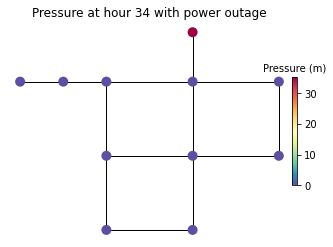

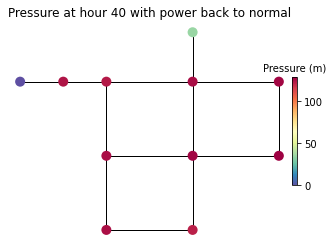

In [21]:
pressure_at_34hr = results_po.node['pressure'].loc[34*3600, :]
pressure_at_40hr = results_po.node['pressure'].loc[40*3600, :]

wntr.graphics.plot_network(wn, node_size=100, 
                           title='Pressure at hour 34 with power outage',
                           node_attribute=pressure_at_34hr, 
                           node_colorbar_label='Pressure (m)')



wntr.graphics.plot_network(wn, node_size=100, 
                           title='Pressure at hour 40 with power back to normal',
                           node_attribute=pressure_at_40hr, 
                           node_colorbar_label='Pressure (m)')

When the power is back to normal the pressure in the system is sufficient again.

WNTR have the opportunity to add a power outage to the network. This shows how the system behaves based on this situation. Every INP file is different, and this can result in various results by using the `add_outage` function. In this water distribution system a power outage did not affect the system because of the water tank supplying enough water. Therefor it was needed to block the water tank out of the system. 

Another problem that occured is that the pump will not start up again when the water tank is blocked because the pump restarts based on the water tank level. To force the pump to start when the power outage is over `add_after_outage` has to be set to `True` in the `add_outage` function.

## Conclusion
Disaster scenarios will always be a risk to water distribution networks. As shown in this notebook, disaster scenarios that can affect the resilience of a water netwrok system, such as pipe closures, fire extinguishing, pipe leaks and power outages can be simulated using the WNTR Python package. These scenarios can influence the hydraulics of the water network, and thereby affecting the water quality. If the network is well planned, the network can handle these scenarios and the water quality can be maintained.